In [10]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math

## Depolarizing noise

Here we are only considering the ideal case where the noise is only present for the delay operation.

In [86]:
noise_model = NoiseModel()

p_err = 0.02
error_1q = depolarizing_error(p_err,1) # 1 qubit depolarizing error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

Preparing the circuit with $|Ψ_{in}⟩ = U_{prep}|0⟩^{⊗n}$ here $θ = \frac{\pi}{2}$

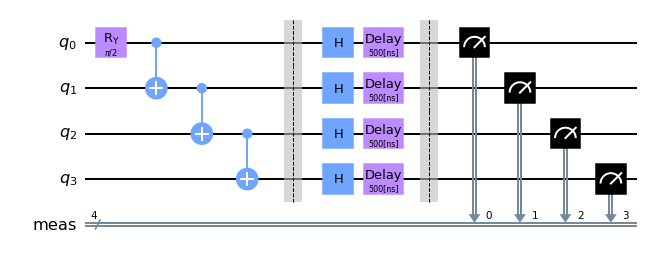

In [113]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  for qubit in range(n_qubits):
    qc.h(qubit)
  return qc

qc = U_prep(4,math.pi/2)
qc.delay(500,unit='ns')
qc.measure_all()
qc.draw('mpl')

### Backend without noise

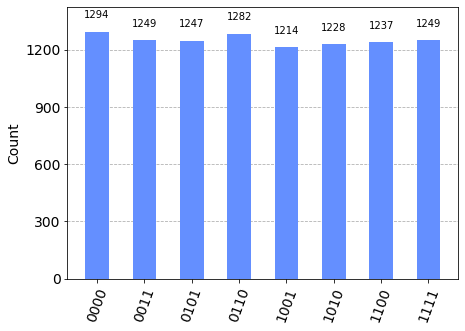

In [114]:
results_ideal = AerSimulator().run(qc,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


### This is our ground truth. Everything we do from here on is to reduce the effect of noise and make $|Ψ_{out}⟩$ as close to this measurement as possible

### Backend with noise

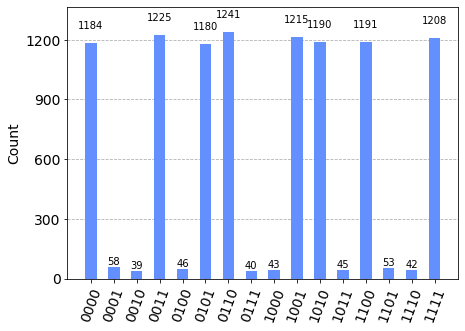

In [115]:
counts = backend.run(qc,shots=10000).result().get_counts()
plot_histogram(counts)

### Our goal is to apply unitary $U$ and $V$ such that the effect noise is reduced by such operation.

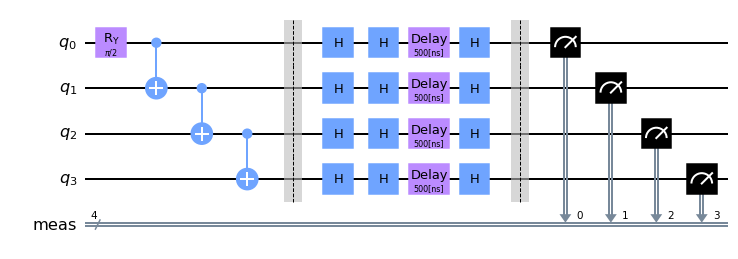

In [116]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.delay(delay,unit='ns')
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.measure_all()
  return qc

qc = padded_circuit(4,math.pi/2, 500)
qc.draw('mpl')


## Now measurement with noise

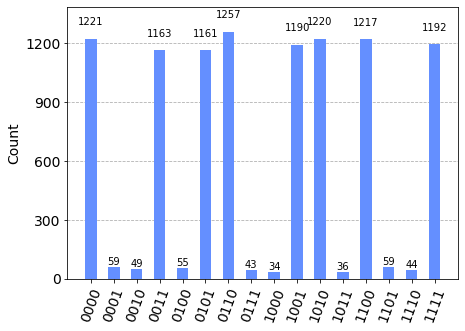

In [139]:
counts = backend.run(qc,shots=10000).result().get_counts()
plot_histogram(counts)

### To measure the amount of noise in all the ways we could pad the circuit, we are defining some simple cost measurement functions:

From analysis of our circuit without any noise, we see the only valid states are 
$|0000⟩\ |0011⟩\ |0101⟩\ |0110⟩\ |1001⟩\ |1010⟩\ |1100⟩\ |1111⟩$

In [150]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '0011') and (state != '0101') and (state != '0110') and (state != '1001') and (state != '1010') and (state != '1100') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 1250/10000
    else:
      diff += abs(counts[state]-1250) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }
print(f"Error with noise: {cost(counts)}")
print(f"Error without noise: {cost(counts_ideal)}")

Error with noise: {'invalid_states_count': 379, 'deviation': 393, 'error': 0.0772}
Error without noise: {'invalid_states_count': 0, 'deviation': 152, 'error': 0.0152}


### Now we iterate over all different possible types of gates and calculate their respective errors

In [ ]:
# Complete this function

def pad_circuit_with_gates(n_qubits,theta,gates,delay):
  qc = U_prep(n_qubits,theta)
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.delay(delay,unit='ns')
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.measure_all()
  return qc